# CASA0006 Practical 3: Tree-based methods
## 0.1 Import Libs and Data Overview

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error

# CART
from sklearn.tree import DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# feature importance
import rfpimp

# xgboost
import xgboost
from xgboost import XGBRegressor

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

check the library version before we start

In [2]:
print("xgboost version:{}".format(xgboost.__version__))
print("sklearn version:{}".format(sklearn.__version__))

xgboost version:2.0.3
sklearn version:1.3.2



Data Loading and Exploration

The dataset you will use relates to daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C., along with weather and seasonal information. The goal here is to predict how many bikes will be rented depending on the weather and the day. The original data can be downloaded from the UCI Machine Learning Repository.

The dataset used in this workshop has been slightly processed by Christoph Molnar using the processing R-script from this Github repository. Here, the dataset is provided as a csv file on Moodle.

Here is a list of the variables in the dataset:

- Count of bicycles including both casual and registered users. The count is used as the response in the regression task.
- Indicator of the season, either spring, summer, fall or winter.
- Indicator whether the day was a holiday or not.
- The year: either 2011 or 2012.
- Number of days since the 01.01.2011 (the first day in the dataset). This predictor was introduced to take account of the trend over time.
- Indicator whether the day was a working day or weekend.
- The weather situation on that day. One of:
    - 'GOOD': including clear, few clouds, partly cloudy, cloudy
    - 'MISTY': including mist + clouds, mist + broken clouds, mist + few clouds, mist
    - 'RAIN/SNOW/STORM': including light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds, heavy rain + ice pallets + thunderstorm + mist, snow + mist
- Temperature in degrees Celsius.
- Relative humidity in percent (0 to 100).
- Wind speed in km/h.

We will use Pandas package to load and explore this dataset:

- Import the Boston housing dataset as a Pandas dataframe (call it bike_rental)
- Inspect the data
- Calculate summary statistics on all attributes



In [3]:
bike_rental = pd.read_csv('https://raw.githubusercontent.com/huanfachen/Spatial_Data_Science/main/Dataset/daily_count_bike_rental.csv')
# drop the year variable as it is not useful
bike_rental = bike_rental.drop(['yr'], axis=1)

In [4]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cnt              731 non-null    int64  
 1   season           731 non-null    object 
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 62.9+ KB


## 0.2 DIY Bootstrap Test:

In bike_rental, there are two data types: categorical (aka object), and numerical (including int64 and float64).

In [5]:
# print a few rows of this dataset
bike_rental.head()

,cnt,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,985,SPRING,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.1758,80.5833,10.7499,0
1,801,SPRING,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.0835,69.6087,16.6521,1
2,1349,SPRING,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.2291,43.7273,16.6367,2
3,1562,SPRING,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.4000,59.0435,10.7398,3
4,1600,SPRING,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.6670,43.6957,12.5223,4



Converting categorical variables

Before undertaking regression, we need to handle categorical variables, as ML models usually can't deal with strings or categories.

While there are other ways of handling categorical variables in machine learning, we will stick to one-hot encoding, as it is easy to understand and appropriate for medium-size datasets (sample size <10000).

First, we need to convert categorical variables into dummy/indicator variables, using **One-Hot Encoding.**


In [4]:

bike_rentail_numeric = pd.get_dummies(bike_rental)

bike_rentail_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   temp                        731 non-null    float64
 2   hum                         731 non-null    float64
 3   windspeed                   731 non-null    float64
 4   days_since_2011             731 non-null    int64  
 5   season_FALL                 731 non-null    bool   
 6   season_SPRING               731 non-null    bool   
 7   season_SUMMER               731 non-null    bool   
 8   season_WINTER               731 non-null    bool   
 9   mnth_APR                    731 non-null    bool   
 10  mnth_AUG                    731 non-null    bool   
 11  mnth_DEZ                    731 non-null    bool   
 12  mnth_FEB                    731 non-null    bool   
 13  mnth_JAN                    731 non

In [5]:
bike_rental_final = bike_rentail_numeric.drop(['season_SPRING', 'mnth_JAN', 'holiday_NO HOLIDAY', 'weekday_MON', 'workingday_WORKING DAY', 'weathersit_GOOD'], axis=1)

# double check the result
bike_rental_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   temp                        731 non-null    float64
 2   hum                         731 non-null    float64
 3   windspeed                   731 non-null    float64
 4   days_since_2011             731 non-null    int64  
 5   season_FALL                 731 non-null    bool   
 6   season_SUMMER               731 non-null    bool   
 7   season_WINTER               731 non-null    bool   
 8   mnth_APR                    731 non-null    bool   
 9   mnth_AUG                    731 non-null    bool   
 10  mnth_DEZ                    731 non-null    bool   
 11  mnth_FEB                    731 non-null    bool   
 12  mnth_JUL                    731 non-null    bool   
 13  mnth_JUN                    731 non


Splitting data into random train and test subsets

By default, train_test_split will split the data according to a 75:25 split. Other proportions can be specified, check out the documentation for details.

Remember that the split should be random in order to avoid selection bias. Here, we set random_state=100 to guarantee reproducibility.

From the documentation:

The first argument of this function:

*arrays: sequence of indexables with same length / shape[0]
Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.

The output of this function:

splitting: list, length=2 * len(arrays)
List containing train-test split of inputs.

Here we input two dataframes (X and Y) and will get four outputs (train_x, test_x, train_y, test_y).

## 1.1 Decision Tree


In [21]:
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(bike_rental_final.drop(['cnt'], axis = 1), bike_rental_final.cnt, random_state=random_state_split)

In [22]:


print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))



(548, 28)
(548,)
(183, 28)
(183,)
True
True




In the regression models, we will use the training set to train the model and select hyperparameters. The testing set is only used to report the performance of the finalised model.
Building a CART

We will build a CART to predict the bicycle rental, following two steps:

    Tune the hyperparameters of max_depth and min_samples_split using cross validation;
    Train a final model based on the tuned hyperparameters and evaluate the model performance.

Here, we focus on two hyperparameters that control the stopping criteria of the model training: max_depth and min_samples_split.

max_depth refers to the maximal depth (or height) of a tree. In sklearn, if this value is not specified, the nodes would be expanded until all leaves contain samples of the same y value or until all leaves contain less than min_samples_split samples.

Intuition about max_depth: the larger the maximum tree depth, the better fitness of the model on the training data and thus the higher possibility of overfitting.

Ideally, we want the maximum tree height to be neither too small or too large.

The documentation is as follows:

max_depth: int, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

min_samples_split refers to the minimum number of samples required to split a node. If a node contains less samples than min_samples_split, this node becomes a leaf node and would not split.

The smaller value of min_samples_split, the better fitness of the model and thus the higher possibility of overfitting.

The documentation is as follows (note that the value can be either integer or float, but the meaning is different)

min_samples_split: int or float, default=2
The minimum number of samples required to split an internal node:

If int, then consider min_samples_split as the minimum number.

If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

Tuning the hyperparameters using cross validation

We will use GridSearchCV to find the optimal combination of max_depth and min_samples_split.

Note that in grid search, all combinations of hyperparameters will be tested and compared. In this case, 25 (5*5) different combinations of hyperparameters will be tested.

One question - how to determine the potential values of max_depth and min_samples_split?

For min_samples_split, as it is a positive integer value and the default value is 2, we can set the range as [2,4,6,8,10].

For max_depth, we can build a decision tree using default settings and check the tree depth, then choose the range around this tree depth.

The code below shows that the tree depth of a CART with default settings is 25, so we can set the range as [10,20,30,40,50].


In [23]:
# a CART using default settings
cart_default = DecisionTreeRegressor(random_state=0)
cart_default.fit(train_x, train_y)
# print the tree depth
print("Tree depth: {}".format(cart_default.get_depth()))

Tree depth: 25


In [24]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
dt = DecisionTreeRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(dt, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 8}
The best score is: 
0.7549920033546205


Training the final CART

In [25]:


dt_final = DecisionTreeRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
dt_final.fit(train_x, train_y)



DecisionTreeRegressor(max_depth=10, min_samples_split=8, random_state=10000)

In [26]:
print("R2 on the training data:")
print(dt_final.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(dt_final.score(X=test_x, y=test_y))

R2 on the training data:
0.9727089518051003
R2 on the testing data:
0.757715812742848


In [27]:


print("RMSE on the training data:")
print(mean_squared_error(train_y, dt_final.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, dt_final.predict(test_x), squared=False))



RMSE on the training data:
322.91814665797057
RMSE on the testing data:
922.8954973299212




The RMSE is in the same unit of the y variable (bicycle rental). On the testing data, on average, the model's prediction deviates from the true bicycle rental by 922.

If you want to know the relative error, you can compute the normalised RMSE by dividing the mean true value, as follows:


In [28]:


print("Normalised RMSE on the training data:")
print(mean_squared_error(train_y, dt_final.predict(train_x), squared=False)/np.mean(train_y))
print("Normalised RMSE on the testing data:")
print(mean_squared_error(test_y, dt_final.predict(test_x), squared=False)/np.mean(test_y))



Normalised RMSE on the training data:
0.0722168443537336
Normalised RMSE on the testing data:
0.2005120261136868



Interpreting the CART

In [29]:


# some attributes of the tree
print("Tree depth:{}".format(dt_final.get_depth()))
print("Number of leaves:{}".format(dt_final.get_n_leaves()))



Tree depth:10
Number of leaves:114




There are different ways to inspect and interpret the CART.

One way is to visualise the whole tree and check each node and split. However, this is not easy for a tree with 10 layers and over 100 leaves.

Another way is to check the relative importance of each feature, for example, using the permutation feature importance.

To do this, we will use the rfpimp package.

rfpimp is short for random forest permutation importance. It is a library that provides feature importances, based upon the permutation importance strategy, for general scikit-learn models and implementations specifically for random forest out-of-bag scores. Built by Terence Parr and Kerem Turgutlu.

We will use the rfpimp.importances function to compute the feature importance. According to its documentation:

Compute permutation feature importances for scikit-learn models using a validation set.
Given a Classifier or Regressor in model and validation X and y data, return a data frame with columns.
Feature and Importance sorted in reverse order by importance.
The validation data is needed to compute model performance measures (accuracy or R^2). The model is not retrained.

So the importance of a feature x is defined as the difference of the R^2 model score (computed by dt_final.score()) after shuffling x and without shuffling x.

The feature importance is mostly positive or a negative value very close to zero, as shuffling a feature is not expected to greatly improve the model performance.

The feature importance is usually used to compare the relative importance of features. It is not recommended to interpret the absolute value of this importance.


In [30]:


# the importances function returns a dataframe of two columns, Feature and Importance, and the features are ranked from the most important to the least.
imp = rfpimp.importances(dt_final, test_x, test_y)
print(imp)



                                                         Importance
Feature                                                            
days_since_2011                                              0.9663
temp                                                         0.4974
hum                                                          0.0598
weathersit_RAIN/SNOW/STORM                                   0.0132
windspeed                                                    0.0131
weekday_SAT                                                  0.0107
mnth_JUN                                                     0.0089
weekday_WED                                                  0.0072
weekday_TUE                                                  0.0019
mnth_OKT                                                     0.0012
holiday_HOLIDAY                                              0.0008
season_SUMMER                                                0.0000
weekday_SUN                                     

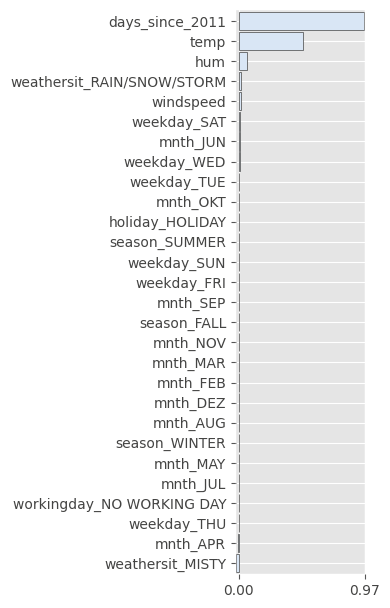

In [31]:
## Here is a barplot of the feature importance
viz = rfpimp.plot_importances(imp)
viz.view()


## 2.1 Building and interpreting a random forest

In this part, we will use the random forest method to predict the daily bicycle rental. We will follow a simple workflow as CART: tune the hyperparameters and then train the final model.

RF has two groups of hyperparameters:

    The hyperparameters of decision trees, such as max_depth, min_samples_split;
    The configurations of RF, such as the number of trees (called n_estimators). By default, n_estimators is set as 100. Some intuition is that the larger n_estimators, the more stable the model performance and the longer computing time. This is because the computing time is a linear function of the number of trees.

The default value of 100 trees is good for most applications, so we don't tune this hyperparameter here.

As with CART, we will focus on the tuning of max_depth and min_samples_split.


In [13]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 30, 'min_samples_split': 2}
The best score is: 
0.8594678489298346


In [14]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=30, random_state=10000)

In [15]:
print("R2 on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R2 on the training data:
0.9818090978256703
R2 on the testing data:
0.883608777650514


In [16]:

#mse_scores = -scores

# Calculate RMSE for each fold
#rmse_scores = np.sqrt(mse_scores)
print("RMSE on the training data:")

print(mean_squared_error(train_y, rf_final.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, rf_final.predict(test_x), squared=False))

RMSE on the training data:
263.63888257826613
RMSE on the testing data:
639.6613442103948


                                                         Importance
Feature                                                            
days_since_2011                                              0.8465
temp                                                         0.4803
hum                                                          0.0706
windspeed                                                    0.0176
weathersit_RAIN/SNOW/STORM                                   0.0039
workingday_NO WORKING DAY                                    0.0032
weekday_SUN                                                  0.0031
weekday_SAT                                                  0.0024
season_WINTER                                                0.0024
weathersit_MISTY                                             0.0024
weekday_FRI                                                  0.0019
holiday_HOLIDAY                                              0.0018
mnth_DEZ                                        

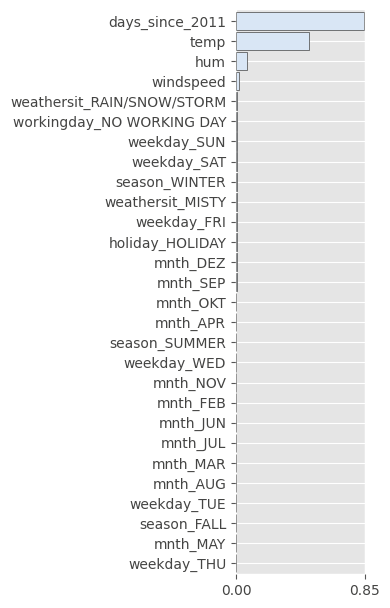

In [17]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

## 2.2 Plotting RF Metrics

/home/mengyuwsl/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/mengyuwsl/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/mengyuwsl/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/mengyuwsl/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/mengyuwsl/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/mengyuwsl/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning:

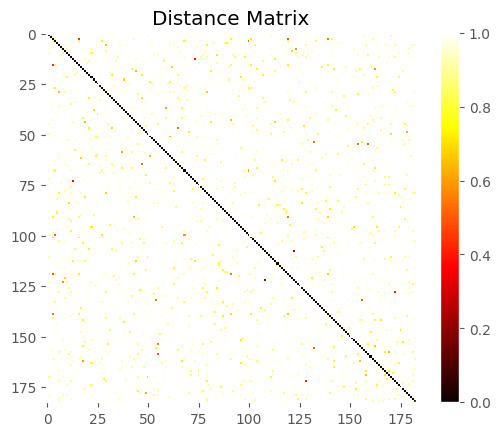

In [18]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Assuming rf_final is your trained RandomForestRegressor and test_x is your test data
# Initialize an empty matrix for the proximity matrix
proximity_matrix = np.zeros((test_x.shape[0], test_x.shape[0]))

# Populate the proximity matrix
for tree in rf_final.estimators_:
    leaf_indices = tree.apply(test_x)
    for i in range(test_x.shape[0]):
        for j in range(test_x.shape[0]):
            if leaf_indices[i] == leaf_indices[j]:
                proximity_matrix[i, j] += 1

# Normalize the proximity matrix
proximity_matrix = proximity_matrix / rf_final.n_estimators

# Now, you can calculate the distance matrix as the inverse of the proximity matrix
# or use any other suitable method
# Here we use 1 - proximity as a simple approach
distance_matrix = 1 - proximity_matrix

# Plot the distance matrix
import matplotlib.pyplot as plt
plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Distance Matrix')
plt.show()


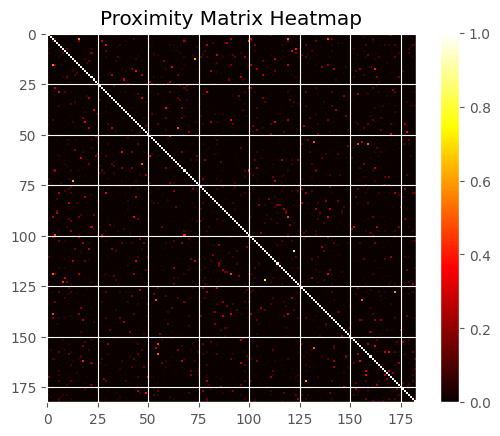

In [19]:
import matplotlib.pyplot as plt

# Assuming proximity_matrix is your proximity matrix
plt.imshow(proximity_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Proximity Matrix Heatmap')
plt.show()


/home/mengyuwsl/.local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


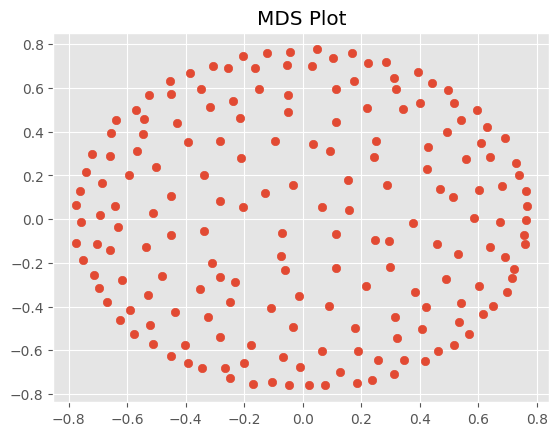

In [20]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
## mds plot:
# Assuming distance_matrix is your distance matrix
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(distance_matrix)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.title('MDS Plot')
plt.show()


## 2.3 Interpretin the MDS Plot:
From this MDS plot:
1. Data points are quite homogeneous
2. However, this may indicate that RF regressor did not find out clear distinctions between the data.

## 3. Building and interpreting a XGBoost

In this part, we will use the XGBoost method to predict the daily bicycle rental. We will follow a simple workflow as CART and RF: tune the hyperparameters and then train the final model.

XGBoost is not part of the sklearn library but a separate library. It provides the sklearn API so that we can use XGboost in the same way as RandomForestRegressor of sklearn.

XGBoost has two groups of hyperparameters:

    The hyperparameters of decision trees, such as max_depth, min_samples_split;
    The configurations of XGBoost, such as the number of trees (called n_estimators) and regularisation hyperparameters.

Here are a list of potentially important hyperparameters for XGBoost, recommended by this post:

    max_depth: The maximum depth per tree. A deeper tree might increase the performance, but also the complexity and chances to overfit. The value must be an integer greater than 0. Default is 6.

    learning_rate: The learning rate determines the step size at each iteration while your model optimizes toward its objective. A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum. The value must be between 0 and 1. Default is 0.3.

    n_estimators: The number of trees in the ensemble. Equivalent to the number of boosting rounds. The value must be an integer greater than 0. Default is 100.

    colsample_bytree: Represents the fraction of columns to be randomly sampled for each tree. It might improve overfitting.

The value must be between 0 and 1. Default is 1.

    subsample: Represents the fraction of observations to be sampled for each tree. A lower values prevent overfitting but might lead to under-fitting.

The value must be between 0 and 1. Default is 1.

    alpha (reg_alpha): L1 regularization on the weights (Lasso Regression). When working with a large number of features, it might improve speed performances. It can be any integer. Default is 0.

    lambda (reg_lambda): L2 regularization on the weights (Ridge Regression). It might help to reduce overfitting. It can be any integer. Default is 1.

    gamma: Gamma is a pseudo-regularisation parameter (Lagrangian multiplier), and depends on the other parameters. The higher Gamma is, the higher the regularization. It can be any integer. Default is 0.

The last three hyperparameters - alpha, lambda, and gamma - are related to the regularization of the model. In machine learning, regularization is a number of techniques to reduce the model complexity and the chances of overfitting.

If you want to know more about these hyperparameters, you can read the XGBoost documentation.

Here, we will focus on the tuning of max_depth and n_estimators.

One note is that this grid search may take several minutes, which is longer than CART or random forest.


In [7]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'n_estimators':[50,100,150,200,250]}

randomState_xgb = 125
xgb = XGBRegressor(random_state=randomState_xgb)

# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters)

gscv_xgb.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (gscv_xgb.best_params_)
print ("The best score is: ")
print (gscv_xgb.score(train_x, train_y))

The best parameter value is: 
{'max_depth': 10, 'n_estimators': 250}
The best score is: 
0.999999999999653


Train the final XGBoost.

In [8]:
xgb_final = XGBRegressor(max_depth=gscv_xgb.best_params_['max_depth'], n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=randomState_xgb)
xgb_final.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=125, ...)

In [9]:
print("R2 on the training data:")
print(xgb_final.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(xgb_final.score(X=test_x, y=test_y))

R2 on the training data:
0.999999999999653
R2 on the testing data:
0.8273557242046816




So - what do you think about the comparison of R2 on the training and testing data?

The R2 on the testing data of XGBoost is much higher than CART and similar to RF, meaning that XGBoost is much better at making prediction for the unseen data and has a better generality.


In [10]:
print("RMSE on the training data:")
print(mean_squared_error(train_y, xgb_final.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, xgb_final.predict(test_x), squared=False))

RMSE on the training data:
0.0011514251431562696
RMSE on the testing data:
779.0513482158586


As with CART, it is not useful to visualise the trees in a random forest.

Calculate and plot the feature importance of the XGboost model.

Although the feature importance value differs from the CART, the order of the top-ranking variables is the same.

This indicates that these variables are indeed very important for the prediction of bike rental.

                                                         Importance
Feature                                                            
days_since_2011                                              0.7760
temp                                                         0.4832
hum                                                          0.0536
windspeed                                                    0.0294
weathersit_RAIN/SNOW/STORM                                   0.0084
season_WINTER                                                0.0082
weathersit_MISTY                                             0.0060
weekday_TUE                                                  0.0052
weekday_SAT                                                  0.0037
weekday_FRI                                                  0.0026
workingday_NO WORKING DAY                                    0.0024
weekday_WED                                                  0.0012
mnth_SEP                                        

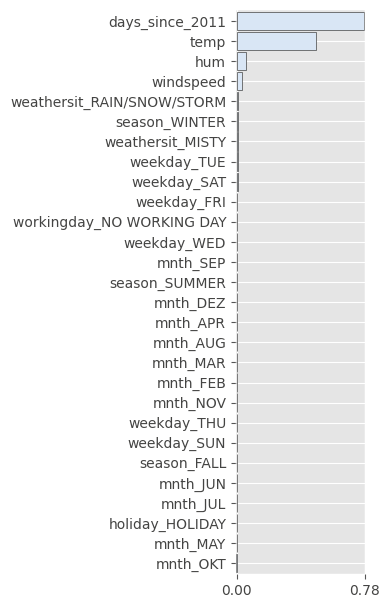

In [11]:
imp = rfpimp.importances(xgb_final,  test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

Comparing three models

we will collate and compare the model performance of the three models.

In [32]:
# create a list of models
list_name_models = ['CART', 'RF', 'XGBoost']
# use the models from above
list_reg_models = [dt_final, rf_final, xgb_final]

dict_models = dict()

for name, model in zip(list_name_models, list_reg_models):
    dict_models[name] = [model.score(train_x, train_y), model.score(test_x, test_y), model.score(train_x, train_y) - model.score(test_x, test_y)]

# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_models, orient='index', columns=['R2_train_data', 'R2_test_data', 'R2_diff'])
df_models
# you can then export df_models as a csv file and use it in MS Excel or Word
# df_models.to_csv(...)

,R2_train_data,R2_test_data,R2_diff
CART,0.9727,0.7577,0.2150
RF,0.9818,0.8836,0.0982
XGBoost,1.0000,0.8274,0.1726




In this workshop, we have used decision trees, random forest, and gradient boosting decision trees to make predictions for the daily bicycle rental.

We compare the model performance and the feature importance. Overall, the RF and GBDT models have better predictive performance and better generalisation than CART.

The trend of relative feature importance is consistent across the three models. The most important features are days since 2011, temperature, and humidity.

In the later weeks, we will demonstrate the use of these models for classification tasks and the scalability of these models for big data.


Additional Practical:

## Ensemble!
### Basic Mathods in Ensemble Learning

Use these for practical 3:

Bagging(Bootstrap Aggregating)

Boosting

Stacking


Bootstrap, bagging, boosting, and stacking are all ensemble techniques used in machine learning, but they differ in their approaches and objectives. Let's break down each one:
1. Bootstrap

    Bootstrap is a statistical method used to sample a dataset. It involves randomly selecting a sample of data from a dataset, with replacement. This means the same data point can be picked more than once.
    In machine learning, bootstrap samples are often used in ensemble methods to create different training datasets. Each model in the ensemble is then trained on a different bootstrap sample.

2. Bagging (Bootstrap Aggregating)

    Bagging is an ensemble technique that improves the stability and accuracy of machine learning algorithms. It reduces variance and helps to avoid overfitting.
    In bagging, multiple models (often of the same type) are trained independently on different bootstrap samples of the dataset. The final prediction is made by averaging the predictions of each model (for regression) or by majority voting (for classification).
    A classic example of bagging is the Random Forest algorithm, where multiple decision trees are trained on different samples of the dataset.

3. Boosting

    Boosting is another ensemble technique, but unlike bagging, the models are not trained independently of each other. Instead, they are trained sequentially, with each new model focusing on the data points that were incorrectly predicted by the previous ones.
    The idea is to improve the accuracy by continuously giving more weight to the misclassified observations, so that subsequent models focus more on these difficult cases.
    Boosting often leads to better predictive accuracy than bagging, but it can also be more prone to overfitting if not managed properly.
    Examples include AdaBoost, Gradient Boosting, and XGBoost.

4. Stacking

    Stacking (or stacked generalization) involves training a new model to combine the predictions of several other models.
    In stacking, different models are trained on the same dataset, and a new model, often called a meta-model, is trained to make a final prediction based on the predictions of the other models.
    The base models can be of different types (e.g., decision tree, logistic regression, etc.), and the meta-model learns how best to combine their predictions.
    Stacking is often used when the goal is to push the performance a bit further after exploiting simpler methods like bagging or boosting.

Summary

    Bootstrap is a method for creating multiple versions of a dataset through random sampling with replacement.
    Bagging reduces variance by training multiple models in parallel on different bootstrap samples and averaging their predictions.
    Boosting improves accuracy by training multiple models sequentially, each focusing on the errors of the previous ones.
    Stacking combines the predictions of multiple models using a meta-model, capitalizing on their individual strengths.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
bike_rental = pd.read_csv('https://raw.githubusercontent.com/huanfachen/Spatial_Data_Science/main/Dataset/daily_count_bike_rental.csv')

In [34]:
# Import the class
from diy_func.diy_ensemble import diy_ensemble

# Create an instance of the class
ensemble = diy_ensemble(3,bike_rental, 100, 100, 100)

ensemble.diy_boostrap(bike_rental, 100, 100, 100)
#diy_boostrap(bike_rental, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100)

[      cnt  season mnth     holiday weekday      workingday       weathersit  \
 520  6998  SUMMER  JUN  NO HOLIDAY     MON     WORKING DAY             GOOD   
 79   2077  SUMMER  MAR  NO HOLIDAY     MON     WORKING DAY            MISTY   
 350  2739  WINTER  DEZ  NO HOLIDAY     SAT  NO WORKING DAY            MISTY   
 53   1917  SPRING  FEB  NO HOLIDAY     WED     WORKING DAY             GOOD   
 578  7580    FALL  AUG  NO HOLIDAY     WED     WORKING DAY             GOOD   
 526  6598  SUMMER  JUN  NO HOLIDAY     SUN  NO WORKING DAY             GOOD   
 280  5409  WINTER  OKT  NO HOLIDAY     SAT  NO WORKING DAY             GOOD   
 655  7461  WINTER  OKT  NO HOLIDAY     WED     WORKING DAY             GOOD   
 228  4694    FALL  AUG  NO HOLIDAY     WED     WORKING DAY             GOOD   
 316  3717  WINTER  NOV  NO HOLIDAY     SUN  NO WORKING DAY             GOOD   
 570  7592    FALL  JUL  NO HOLIDAY     TUE     WORKING DAY             GOOD   
 507  6073  SUMMER  MAY  NO HOLIDAY     

In [35]:
ensemble.diy_boostrap(bike_rental, 5, 2, 100)

[      cnt  season mnth     holiday weekday   workingday weathersit  \
 520  6998  SUMMER  JUN  NO HOLIDAY     MON  WORKING DAY       GOOD   
 79   2077  SUMMER  MAR  NO HOLIDAY     MON  WORKING DAY      MISTY   
 
                                         temp  \
 520                                  20.0825   
 79                                   12.2304   
 
                                          hum  \
 520                                  48.7083   
 79                                   73.7391   
 
                                    windspeed  days_since_2011  
 520                                  19.0838              520  
 79                                   19.3485               79  ,
       cnt  season mnth     holiday weekday      workingday weathersit  \
 350  2739  WINTER  DEZ  NO HOLIDAY     SAT  NO WORKING DAY      MISTY   
 53   1917  SPRING  FEB  NO HOLIDAY     WED     WORKING DAY       GOOD   
 
                                         temp  \
 350              

In [36]:
bootstrapped_bike_rental = ensemble.diy_boostrap(bike_rental, 5,2,100)

In [37]:
bootstrapped_bike_rental

[      cnt  season mnth     holiday weekday   workingday weathersit  \
 520  6998  SUMMER  JUN  NO HOLIDAY     MON  WORKING DAY       GOOD   
 79   2077  SUMMER  MAR  NO HOLIDAY     MON  WORKING DAY      MISTY   
 
                                         temp  \
 520                                  20.0825   
 79                                   12.2304   
 
                                          hum  \
 520                                  48.7083   
 79                                   73.7391   
 
                                    windspeed  days_since_2011  
 520                                  19.0838              520  
 79                                   19.3485               79  ,
       cnt  season mnth     holiday weekday      workingday weathersit  \
 350  2739  WINTER  DEZ  NO HOLIDAY     SAT  NO WORKING DAY      MISTY   
 53   1917  SPRING  FEB  NO HOLIDAY     WED     WORKING DAY       GOOD   
 
                                         temp  \
 350              

### Now bagging

### Boosting

### Stacking

# Superseded Code:

In [ ]:
def boostrap_diy(input_df, n_bootstrap, n_sample, random_state=None):
    """
    This function performs bootstrap sampling on a pandas dataframe.

    ------------------------------
    Parameters
    ----------
    input_df : pandas dataframe
        The input dataframe.

    n_bootstrap : int
        The number of bootstrap samples.

    n_sample : int
        The number of samples in each bootstrap sample.

    random_state : int
        The random seed.

    ------------------------------
    Returns
    -------
    bootstrap_samples : list of DataFrames
        List containing the bootstrap samples.
    """
    if random_state is not None:
        np.random.seed(random_state)

    bootstrap_samples = []
    n_rows = input_df.shape[0]

    for _ in range(n_bootstrap):
        # Generate random indices for the bootstrap sample
        random_indices = np.random.randint(0, n_rows, size=n_sample)
        # Select rows corresponding to the random indices
        sample = input_df.iloc[random_indices]
        bootstrap_samples.append(sample)

    return bootstrap_samples